In [93]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import math
import re

In [94]:
ppt = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/ppt_prism_new_york_data.csv')
tmean = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_new_york_data.csv')
#forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/foraging_quality_pennsylvania_data.csv')
forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_new_york_data.csv')

cols = tmean.columns.tolist()

# create new columns 
new_cols = []
for col in cols:
    if "Forage" in col:
        code = col.split("_")[1]
        number = re.findall(r'\d+', code)[0]
        new_cols.append(number)
    else:
        new_cols.append(col)

new_cols

# rename columns
tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))

# create grid_id column
tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

possible_cols = tmean.col.tolist()
possible_rows = tmean.row.tolist()

forage["grid_id"] = forage["col"].astype(str) + "_" + forage["row"].astype(str)

def getGridForageQuality(col, row, year, forage=forage):
    grid_id = str(col) + "_" + str(row)
    try:
        #return forage.query(f" grid_id == '{grid_id}' and year == {year}")['Forage_spring_1km'].values[0]
        return float(forage.query(f" grid_id == '{grid_id}' ")['sprng__'].values[0])
    except:
        return getGridForageQuality(col, row, year + 1)


def getGridForageQuality_vectorized(cols, rows, years,forage=forage):
    # Ensure grid_id is available in the forage DataFrame
    grid_ids = str(cols) + "_" + str(rows)

    # Match grid_id and year across entire DataFrame without looping
    mask = (forage['grid_id'].isin(grid_ids)) & (forage['year'].isin(years))

    # Extract the corresponding forage quality values
    #forage_quality = forage.loc[mask, 'Forage_spring_1km']
    forage_quality = forage.loc[mask, 'spring__']

    return forage_quality

################# tmean data #################

cols = tmean.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_tmean" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)
new_cols

tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))


tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

def getTmean(col, row, day, month, year, tmean=tmean):
    '''
    Get temperature data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data

    output:
    float, temperature in degrees celcius
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    tmean = tmean[tmean["grid_id"] == grid_id][date].values[0]
    return float(tmean)

############### ppt data #################

cols = ppt.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_ppt" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)

ppt = ppt.rename(columns=dict(zip(ppt.columns, new_cols)))

ppt["grid_id"] = ppt["col"].astype(str) + "_" + ppt["row"].astype(str)

def getPpt(col, row, day, month, year, ppt=ppt):
    '''
    Get precipitation data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    ppt: pd.DataFrame, precipitation data

    output:
    float, precipitation in mm
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    ppt = ppt[ppt["grid_id"] == grid_id][date].values[0]
    return float(ppt)

In [95]:
################ Modeling ################

In [96]:
#grids = pd.read_csv('/Users/edwardamoah/Documents/Dissertation/Osmia_Pop_Simulation/pennsylvania_prism_grid_points_centre_county.csv')
#grids["grid_id"] = grids["col"].astype(str) + "_" + grids["row"].astype(str)
#grids = grids[["col", "row", "grid_id"]]
#grids

In [97]:
### create a function to get the tmean data between a dates 

# this is the extraction of tmean to calculate emergence for 2023

prepareTmean_dict = {}
def prepareEmergenceTmean(year, tmean=tmean):
    '''
    Prepare tmean for a given year for emergence calculation

    it return the data for tmean from November of the previous year to December of the current year
    '''

    if year in prepareTmean_dict:
        return prepareTmean_dict[year]
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    tmean_11 = tmean_copy.filter(like=f"year_{year-1}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year-1}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_year = tmean_copy.filter(like=f"year_{year}")
    tmean_year['grid_id'] = tmean['grid_id']

    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_year, on='grid_id')

    #tmean_merge = tmean_year # remove the 11 and 12 months data

    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    prepareTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [98]:
def getEmergence_vector(col, row, year):
    
    dev_threshold = 6.53
    cumulative_threshold = 209

    tmean_merge = prepareEmergenceTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
    arr_4 = arr_3.cumsum()
    first_element_index = np.argwhere(arr_4 > cumulative_threshold)[0][0]

    emergence = datetime(year-1,11,1) + timedelta(days= int(first_element_index) + 1)
    #emergence = datetime(year,1,1) + timedelta(days= int(first_element_index) + 1)
    return datetime.fromtimestamp(emergence.timestamp())
    #return emergence#.strftime("%Y-%m-%d")

In [99]:
preWinterTmean_dict = {}
def preparePreWinterTmean(year):
    if year in preWinterTmean_dict:
        return preWinterTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for september and october
    tmean_09 = tmean_copy.filter(like=f"year_{year}09")
    tmean_09['grid_id'] = tmean['grid_id']
    tmean_10 = tmean_copy.filter(like=f"year_{year}10")
    tmean_10['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_09, tmean_10, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    preWinterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [100]:
def getPreWinteringMortality_vector(col, row, year, pre_winter_delta=0.0025):

    #dev_threshold = 6.53
    dev_threshold = 15

    tmean_merge = preparePreWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
   
    count = np.count_nonzero(arr_3 > 0)


    return {
        "mortality": count * pre_winter_delta,
        "dev_days": count,
        "cumulative_degrees": np.sum(arr_3)
    }


In [101]:
# prepare winter temperature data
winterTmean_dict = {}
def prepareWinterTmean(year):
    if year in winterTmean_dict:
        return winterTmean_dict[year]

    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for November, December and January to June of the next year
    tmean_11 = tmean_copy.filter(like=f"year_{year}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_01 = tmean_copy.filter(like=f"year_{year+1}01")
    tmean_01['grid_id'] = tmean['grid_id']
    tmean_02 = tmean_copy.filter(like=f"year_{year+1}02")
    tmean_02['grid_id'] = tmean['grid_id']
    tmean_03 = tmean_copy.filter(like=f"year_{year+1}03")
    tmean_03['grid_id'] = tmean['grid_id']
    tmean_04 = tmean_copy.filter(like=f"year_{year+1}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year+1}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year+1}06")
    tmean_06['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_01, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_02, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_03, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_04, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')


    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    winterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [102]:
def getWinteringTemperature_vector(col,row, year):
    dev_threshold = 6.53
    tmean_merge = prepareWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    #winter_temp = np.mean(arr_1)

    # filter for the days between November 1 and emergence date
    emergence = getEmergence_vector(col, row, year+1)
    #print(emergence)
    winter_date = datetime(year, 11, 1)
    temps = arr_1[:((emergence - winter_date).days)].tolist()
    winter_temp = np.mean(temps)
    
    if winter_temp > dev_threshold:
        return {
            "winter_temp": winter_temp,
            "mortality": 0.5,
            "temps": temps
        }
    else:
        return {
            "winter_temp": winter_temp,
            "mortality": 0,
            "temps": temps
        }


In [103]:
# prepare winter temperature data
reproductionTmean_dict = {}
def prepareReproductionTmean(year):
    if year in reproductionTmean_dict:
        return reproductionTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    tmean_07 = tmean_copy.filter(like=f"year_{year}07")
    tmean_07['grid_id'] = tmean['grid_id']

    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_07, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [104]:
# prepare winter temperature data
reproductionPpt_dict = {}
def prepareReproductionPpt(year):
    if year in reproductionPpt_dict:
        return reproductionPpt_dict[year]
    
    # copy and rename columns
    tmean_copy = ppt.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionPpt_dict[year] = tmean_merge
    
    return tmean_merge

In [105]:
# define vectorize reproduction function

def getSpatiallyExplicitReproduction_vector(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):

    starting_date = emergence + timedelta(days=mating_days)

    data_start = datetime(emergence.year, 4, 1)

    forage_quality = getGridForageQuality(col, row, emergence.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    # prepare temperature data
    tmean_merge = prepareReproductionTmean(emergence.year)

    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_t1 = arr_t[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_t2 = np.where(arr_t1 >= temperature_threshold, 1, 0)

    # prepare precipitation data
    ppt_merge = prepareReproductionPpt(emergence.year)
    arr_p =  ppt_merge[(ppt_merge['col'] == col) & (ppt_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_p1 = arr_p[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_p2 = np.where(arr_p1 < precipitation_threshold, 1, 0)


    arr_c = arr_t2 & arr_p2

    arr_c.sum()

    eggs = arr_c.sum() * egg_delta
    non_foraging_days = (longevity - mating_days) - arr_c.sum()
    precipitation_effect = (longevity - mating_days) - arr_p2.sum()
    temperature_effect = (longevity - mating_days) - arr_t2.sum()
    temps = arr_t1.tolist()
    ppts = arr_p1.tolist()

    egg_days = []
    for i in range(len(arr_c)):
        if arr_c[i] == 1:
            egg_days.append((starting_date + timedelta(days=i)).strftime("%Y-%m-%d")) 

    return {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }


In [106]:
def getEggLarvaMortality_vector(col, row, emergence, reproduction):
    ldt = 10
    udt = 30
    egg_larva_days = 18
    mortality_delta = 0.1
    tmean_merge = prepareReproductionTmean(emergence.year)
    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    data_start = datetime(emergence.year, 4, 1)

    cold_days = []
    hot_days = []
    mortality = []
    for date in reproduction['egg_days']:
        date = datetime.strptime(date, "%Y-%m-%d")
        arr_t1 = arr_t[(date - data_start).days: (date - data_start).days + egg_larva_days]
        arr_t2_h = np.where((arr_t1 <= udt), 0, 1)
        arr_t2_c = np.where((arr_t1 >= ldt) , 0, 1)
        cold_days.append(arr_t2_c.sum())
        hot_days.append(arr_t2_h.sum())
        mortality.append((arr_t2_c.sum() + arr_t2_h.sum()) * mortality_delta)

    mortality = np.mean(mortality)
    if mortality > 1:
        mortality = 1
    
    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }


    return {
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days),
        "mortality": mortality
    }


In [107]:
# Emergence Model
import datetime
from datetime import datetime, timedelta

emergence_dict = {}

def getEmergence(col, row, year):
    '''
    Get emergence date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year

    output:
    datetime.date, emergence date
    '''

    dict_key = str(col) + "_" + str(row) + "_" + str(year)
    if dict_key in emergence_dict:
        return emergence_dict[dict_key]

    # function constants
    thermal_temp = 209 # adam et al
    dev_temp = 6.53 # adam et al


    starting_date = f"{year-1}-11-01" # November 1st of the previous year
    starting_date = datetime.strptime(starting_date, "%Y-%m-%d").date()
    cumulative_degrees = 0.0
    new_date = starting_date

    # determine emergence date
    cumulative_degrees = 0.0
    dev_list = []
    while cumulative_degrees < thermal_temp:
        daily_tmean = getTmean(col, row, new_date.day, new_date.month, new_date.year)
        try:
            if daily_tmean >= dev_temp:
                cumulative_degrees += float(daily_tmean - dev_temp)
                dev_list.append(float(daily_tmean - dev_temp))
            else:
                dev_list.append(0.0)
        except:
            print(col, row, new_date, daily_tmean)
            

        new_date += timedelta(days=1)

    emergence_dict[dict_key] = new_date

    return new_date #, dev_list

In [108]:
# Reproduction Model

reproductive_dict = {}

def getSpatiallyExplicitReproduction(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):
    '''
    Get reproduction date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year
    emergence: datetime.date, emergence date

    output:
    datetime.date, reproduction date
    '''

    print(col, row, emergence)

    # dict_key = str(col) + "_" + str(row) + "_" + emergence.strftime("%Y-%m-%d")
    # if dict_key in reproductive_dict:
    #     return reproductive_dict[dict_key]

    # function constants
    eggs = 0
    egg_delta = 1 # change in eggs per day
     # update starting date
    starting_date = emergence + timedelta(days=mating_days)

    # update egg_delta based on foraging quality
    forage_quality = getGridForageQuality(col, row, starting_date.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    non_foraging_days = 0
    precipitation_effect = 0
    temperature_effect = 0
    temps = []
    ppts = []
    egg_days = []
    
    for i in range(longevity-mating_days):
        # get daily temperature and precipitation
        daily_tmean = getTmean(col, row, starting_date.day, starting_date.month, starting_date.year)
        daily_ppt = getPpt(col, row, starting_date.day, starting_date.month, starting_date.year)

        temps.append(daily_tmean)
        ppts.append(daily_ppt)

        print(daily_tmean, daily_ppt)

        # update eggs
        if daily_tmean >= temperature_threshold and daily_ppt < precipitation_threshold:
            eggs += egg_delta
            egg_days.append(starting_date.strftime("%Y-%m-%d"))
            
        else:
            non_foraging_days += 1
            if daily_tmean < temperature_threshold:
                temperature_effect += 1
            if daily_ppt >= precipitation_threshold:
                precipitation_effect += 1

        # update date
        starting_date += timedelta(days=1)
        

    return_dict = {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }

    # reproductive_dict[dict_key] = return_dict

    return return_dict

In [109]:
# Egg and Larva Mortality Model

def getEggLarvaMortality(col, row, emergence, reproduction, mating_days=2):

    def getEggMortalityProbability(date, tmeans, mortality_delta = 0.1):
        # constants
        ldt = 10 # c
        udt = 30 # c

        prob = 0
        cold_days = 0
        hot_days = 0
        for i in range(18): # 4 egg + 14 larva
            if tmeans[date] < ldt or tmeans[date] > udt:
                prob += mortality_delta
                if tmeans[date] < ldt:
                    cold_days += 1
                if tmeans[date] > udt:
                    hot_days += 1
            date = datetime.strptime(date, "%Y-%m-%d").date()
            date += timedelta(days=1)
            date = date.strftime("%Y-%m-%d")

            

        return {
            "prob": prob,
            "cold_days": cold_days,
            "hot_days": hot_days
        }

    total_dev_days = 38 # days 20 forages + 4 egg + 14 larva

    startdate = emergence + timedelta(days=mating_days)

    tmeans = {}
    for i in range(total_dev_days): # get all the tmeans

        tmeans[startdate.strftime("%Y-%m-%d")] = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        startdate += timedelta(days=1)

    egg_mortalities = []
    cold_days = []
    hot_days = []
    for egg_day in reproduction['egg_days']:
        mortality = getEggMortalityProbability(egg_day, tmeans)
        egg_mortalities.append(mortality['prob'])
        cold_days.append(mortality['cold_days'])
        hot_days.append(mortality['hot_days'])

    egg_mortalities = np.mean(egg_mortalities)
    if egg_mortalities > 1:
        egg_mortalities = 1


    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }

    return {    
        "mortality": egg_mortalities,
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days)
    }


In [110]:
# Pre-wintering Mortality Model

def getPreWinteringMortality(col, row, year, pre_winter_delta=0.0025):

    startdate = datetime(year, 9, 1)
    enddate = datetime(year, 11, 1)

    #dev_temp = 6.53
    dev_temp = 15

    mortality = 0
    dev_days = 0
    cumulative_degrees = 0
    
    while startdate < enddate:
        daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        if daily_tmean > dev_temp:
            mortality += pre_winter_delta
            dev_days += 1
            cumulative_degrees += float(daily_tmean - dev_temp)

        startdate += timedelta(days=1)

    return {
        "mortality": mortality,
        "dev_days": dev_days,
        "cumulative_degrees": cumulative_degrees
    }
    

In [111]:
# Wintering Mortality Model

def getWinteringTemperature(col, row, year):
        
        dev_temp = 6.53
    
        startdate = datetime(year, 11, 1)
        #enddate = datetime(year+1, 2, 1)
        try:
            enddate = getEmergence(col, row, year+1)
            enddate = datetime(enddate.year, enddate.month, enddate.day)
        except:
            enddate = datetime(year+1, 2, 1)

        print(enddate)

        temps = []
    
        while startdate < enddate:
            daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
            temps.append(daily_tmean)
    
            startdate += timedelta(days=1)
        
        winter_temp = np.mean(temps)

        if winter_temp > dev_temp:
            return {
                "winter_temp": winter_temp,
                "mortality": 0.5,
                "temps" : temps
            }
        else:
            return {
                "winter_temp": winter_temp,
                "mortality": 0,
                "temps" : temps
            }

In [112]:
######################## Run Simulation ################

In [113]:
#years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
years = [2015]
#years = [2020, 2021, 2022, 2023]
#years = [2016, 2017, 2018, 2019]

In [114]:
grids = tmean[["Site", "col","row","grid_id"]]

In [115]:
grids

,Site,col,row,grid_id
0,AB,1152,169,1152_169
1,BA,1164,175,1164_175
2,BD,1160,177,1160_177
3,EV,1162,185,1162_185
4,GR,1165,174,1165_174
5,HG,1164,181,1164_181
6,HS,1151,169,1151_169
7,IC,1163,179,1163_179
8,IT,1165,179,1165_179
9,KI,1160,177,1160_177


In [179]:
def getEmergenceData(col, row, year):
    # try:
    #   return getEmergence_vector(col, row, year)
    # except:
    #     print(col, row, year)
    #     return getEmergence(col, row, year)

    # return a timestamp for 7th May 2015
    return datetime.fromtimestamp(1430985600)
    
def getPreWinteringData(col, row, year):
    try:
        return getPreWinteringMortality_vector(col, row, year)
    except:
        print(col, row, year)
        return getPreWinteringMortality(col, row, year)
    
def getWinteringData(col, row, year):
    try:
        return getWinteringTemperature_vector(col, row, year)
    except:
        print(col, row, year)
        return getWinteringTemperature(col, row, year)
    
def getReproductionData(col, row, emergence):
    # try:
    #     return getSpatiallyExplicitReproduction_vector(col, row, emergence, temperature_threshold=9, precipitation_threshold=3)
    # except:
    #     print(col, row, emergence)
    
    return getSpatiallyExplicitReproduction(col, row, emergence, temperature_threshold=5, precipitation_threshold=0.5)
    
def getEggLarvaMortalityData(col, row, emergence, reproduction):
    try:
        return getEggLarvaMortality_vector(col, row, emergence, reproduction)
    except:
        print(col, row, emergence, reproduction)
        return getEggLarvaMortality(col, row, emergence, reproduction)

In [180]:
col =1152
row =169
year = 2015
getEmergenceData(col, row, year)

datetime.datetime(2015, 5, 7, 4, 0)

In [181]:
starting_date = datetime(2015, 5, 7)

In [182]:
#getSpatiallyExplicitReproduction(col, row, datetime(2015, 5, 7), temperature_threshold=10, precipitation_threshold=0.5)

In [183]:
for year in years:
    grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
    grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
    # grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortalityData(x['col'], x['row'], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)
    # grids[f"pre_winter_{year}"] = grids.apply(lambda x: getPreWinteringData(x['col'], x['row'], year), axis=1)
    # grids[f"wintering_{year}"] = grids.apply(lambda x: getWinteringData(x['col'], x['row'], year), axis=1)
   

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/3827176934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/3827176934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)


In [184]:
grids

,Site,col,row,grid_id,emergence_2015,reproduction_2015,eggs,egg_days,foraging_quality,Site_Code
0,AB,1152,169,1152_169,2015-05-07 04:00:00,"{'eggs': 15, 'non_foraging_days': 5, 'precipit...",10,"[2015-05-13, 2015-05-15, 2015-05-17, 2015-05-1...",0.438429,AB
1,BA,1164,175,1164_175,2015-05-07 04:00:00,"{'eggs': 14, 'non_foraging_days': 6, 'precipit...",10,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.364626,BA
2,BD,1160,177,1160_177,2015-05-07 04:00:00,"{'eggs': 14, 'non_foraging_days': 6, 'precipit...",11,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.425636,BD
3,EV,1162,185,1162_185,2015-05-07 04:00:00,"{'eggs': 28, 'non_foraging_days': 6, 'precipit...",16,"[2015-05-09, 2015-05-10, 2015-05-18, 2015-05-2...",0.571365,EV
4,GR,1165,174,1165_174,2015-05-07 04:00:00,"{'eggs': 13, 'non_foraging_days': 7, 'precipit...",9,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.441039,GR
5,HG,1164,181,1164_181,2015-05-07 04:00:00,"{'eggs': 26, 'non_foraging_days': 7, 'precipit...",22,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.526532,HG
6,HS,1151,169,1151_169,2015-05-07 04:00:00,"{'eggs': 15, 'non_foraging_days': 5, 'precipit...",11,"[2015-05-10, 2015-05-13, 2015-05-15, 2015-05-1...",0.344499,HS
7,IC,1163,179,1163_179,2015-05-07 04:00:00,"{'eggs': 14, 'non_foraging_days': 6, 'precipit...",11,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.469469,IC
8,IT,1165,179,1165_179,2015-05-07 04:00:00,"{'eggs': 14, 'non_foraging_days': 6, 'precipit...",11,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.472890,IT
9,KI,1160,177,1160_177,2015-05-07 04:00:00,"{'eggs': 14, 'non_foraging_days': 6, 'precipit...",11,"[2015-05-09, 2015-05-10, 2015-05-15, 2015-05-1...",0.425636,KI


(array([12.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([13. , 14.5, 16. , 17.5, 19. , 20.5, 22. , 23.5, 25. , 26.5, 28. ]),
 <BarContainer object of 10 artists>)

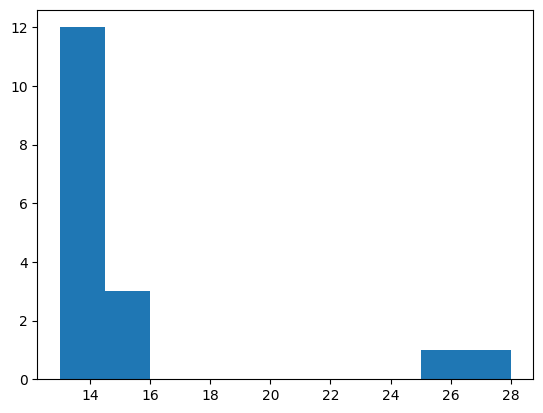

In [185]:
plt.hist([x['eggs'] for x in grids['reproduction_2015']])

In [186]:
grids['eggs'] = [x['eggs'] for x in grids['reproduction_2015']]

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/3713833599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['eggs'] = [x['eggs'] for x in grids['reproduction_2015']]


In [187]:
sim = grids[['Site','col', 'row', 'grid_id', 'eggs']]

In [188]:
exp = pd.read_csv('/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/Centrella_et_al_Data.csv')

In [189]:
exp['Calendar_Date'] = pd.to_datetime(exp['Calendar_Date'])

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/1987595700.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exp['Calendar_Date'] = pd.to_datetime(exp['Calendar_Date'])


In [190]:
exp['Emergence'] = '5/7/2015'
exp['Emergence'] = pd.to_datetime(exp['Emergence'])

In [191]:
exp['Final_Date'] = '24/6/2015'
exp['Final_Date'] = pd.to_datetime(exp['Final_Date'])

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/2319756418.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  exp['Final_Date'] = pd.to_datetime(exp['Final_Date'])


In [192]:
exp[exp['Site_Code'] == 'AB']['Calendar_Date'].tolist()

[Timestamp('2015-05-20 00:00:00'),
 Timestamp('2015-05-28 00:00:00'),
 Timestamp('2015-06-03 00:00:00')]

In [193]:
exp['collection_dates'] = exp['Site_Code'].apply(lambda x: exp[exp['Site_Code'] == x]['Calendar_Date'].tolist())

In [194]:
def getForagingDates(calendar_date, emergence, collection_dates):
    
    # find the most recent date just before the calendar date
    early_date = None
    collection_dates = [x for x in collection_dates if x < calendar_date]
    #print(collection_dates)
    if len(collection_dates) > 0:
        early_date = max(collection_dates)
    else:
        early_date = emergence

    #print(early_date, calendar_date)

    # generate a list of dates between early date and calendar date
    foraging_dates = [early_date + timedelta(days=x) for x in range((calendar_date - early_date).days + 1)]

    return foraging_dates
    


In [195]:
exp['foraging_dates'] = exp.apply(lambda x: getForagingDates(x['Calendar_Date'], x['Emergence'], x['collection_dates']), axis=1)

In [196]:
#grids['reproduction_2015'][0]
grids['egg_days'] = [x['egg_days'] for x in grids['reproduction_2015']]
grids['foraging_quality'] = [x['forage_quality'] for x in grids['reproduction_2015']]

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/2751532849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['egg_days'] = [x['egg_days'] for x in grids['reproduction_2015']]
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/2751532849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['foraging_quality'] = [x['forage_quality'] for x in grids['reproduction_2015']]


In [197]:
grids['Site_Code'] = grids['Site']

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_61693/2648138387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids['Site_Code'] = grids['Site']


In [198]:
#exp.columns.tolist()

In [254]:
dt = grids[['Site_Code', 'col', 'row','foraging_quality', 'egg_days']].merge(exp[['foraging_dates', 'Site_Code',  'Total_Emerged_Males','Total_Emerged_Females','Nest_Tubes for_Offspring_Analysis' ]], on='Site_Code')

In [255]:
dt['measured_eggs'] = (dt['Total_Emerged_Males'] + dt['Total_Emerged_Females'])/dt['Nest_Tubes for_Offspring_Analysis']

#dt['measured_eggs'] = (dt['Total_Emerged_Females'])/dt['Nest_Tubes for_Offspring_Analysis']

In [256]:
def getPredictedEggs(egg_days, foraging_dates, foraging_quality):
    foraging_dates = [x.strftime("%Y-%m-%d") for x in foraging_dates]
    num =  len([x for x in egg_days if x in foraging_dates]) 
    if foraging_quality <= 0.4:
        return num * 1
    else:
        return num * 1.5

In [257]:
dt['predicted_eggs'] = dt.apply(lambda x: getPredictedEggs(x['egg_days'], x['foraging_dates'], x['foraging_quality']), axis=1)

In [258]:
# corr
dt[['measured_eggs', 'predicted_eggs']].corr()

,measured_eggs,predicted_eggs
measured_eggs,1.000000,0.201013
predicted_eggs,0.201013,1.000000


Text(0, 0.5, 'Predicted Eggs')

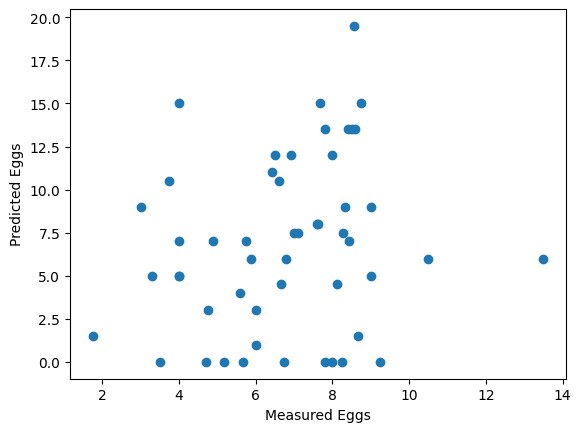

In [259]:
plt.scatter(dt['measured_eggs'], dt['predicted_eggs'])
plt.xlabel('Measured Eggs')
plt.ylabel('Predicted Eggs')

[[1.         0.30735761]
 [0.30735761 1.        ]]
-1.8657821311971126


/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


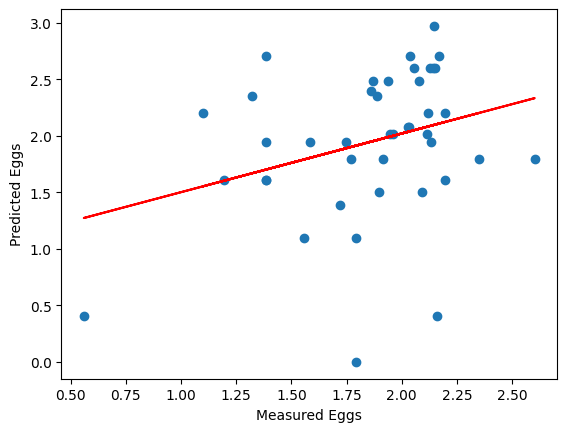

In [295]:
dt['log_measured_eggs'] = np.log(dt['measured_eggs'])
dt['log_predicted_eggs'] = np.log(dt['predicted_eggs'])

# drop inf values
dt1 = dt.replace([np.inf, -np.inf], np.nan)
dt1 = dt1.dropna()

me = dt1['log_measured_eggs']
pe = dt1['log_predicted_eggs']

plt.scatter(me, pe)
plt.xlabel('Measured Eggs')
plt.ylabel('Predicted Eggs')

# print the correlation
print(np.corrcoef(me, pe))

# print the r squared
from sklearn.metrics import r2_score

print(r2_score(dt1['log_measured_eggs'], dt1['log_predicted_eggs']))

# get the regression line
from sklearn.linear_model import LinearRegression

X = dt1['log_measured_eggs'].values.reshape(-1,1)
y = dt1['log_predicted_eggs'].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)

reg.coef_

# plot regression line
#plt.scatter(X, y)
plt.plot(X, reg.predict(X), color='red')




In [272]:
def getTmeans(col, row, foraging_dates):
    tmeans = []
    for date in foraging_dates:
        tmeans.append(getTmean(col, row, date.day, date.month, date.year))
    return tmeans

def getPpts(col, row, foraging_dates):
    ppts = []
    for date in foraging_dates:
        ppts.append(getPpt(col, row, date.day, date.month, date.year))
    return ppts

In [273]:
dt['tmeans'] = dt.apply(lambda x: getTmeans(x['col'], x['row'], x['foraging_dates']), axis=1)
dt['ppts'] = dt.apply(lambda x: getPpts(x['col'], x['row'], x['foraging_dates']), axis=1)

In [274]:
dt['tmean'] = dt['tmeans'].apply(lambda x: np.mean(x))
dt['ppt'] = dt['ppts'].apply(lambda x: np.mean(x))

In [276]:
dt['residuals'] = dt['measured_eggs'] - dt['predicted_eggs']

ShapiroResult(statistic=np.float64(0.9759935700853611), pvalue=np.float64(0.38499106913674164))

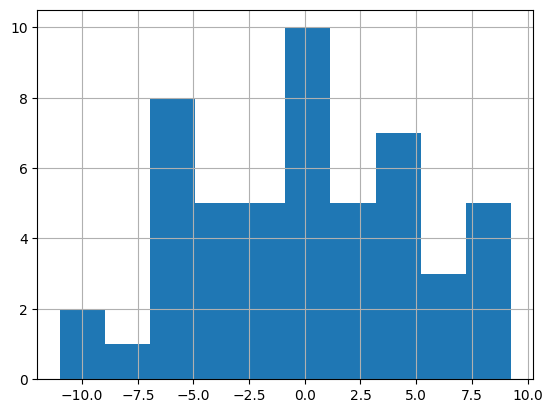

In [292]:
dt['residuals'].hist()

# check normality for residuals
from scipy.stats import shapiro

shapiro(dt['residuals'])

In [293]:
dt1['log_residuals'] = dt1['log_measured_eggs'] - dt1['log_predicted_eggs']

ShapiroResult(statistic=np.float64(0.9345847028242726), pvalue=np.float64(0.018553699427941897))

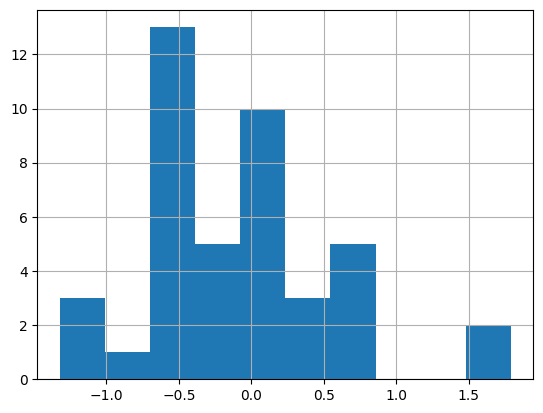

In [294]:
dt1['log_residuals'].hist()

# check normality for residuals
from scipy.stats import shapiro

shapiro(dt1['log_residuals'])

-73.16877823880256

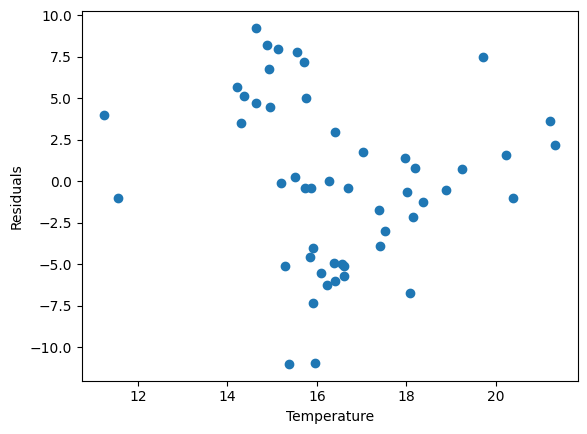

In [291]:
# scatter plot for residuals and tmean
plt.scatter(dt['tmean'], dt['residuals'])
plt.xlabel('Temperature')
plt.ylabel('Residuals')

r2_score(dt['tmean'], dt['residuals'])

-5.757772533821399

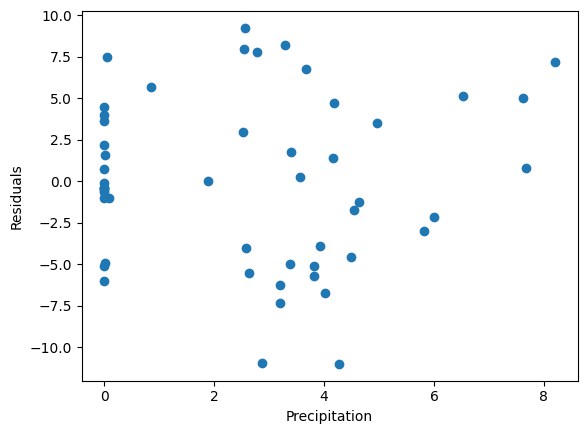

In [290]:
plt.scatter(dt['ppt'], dt['residuals'])
plt.xlabel('Precipitation')
plt.ylabel('Residuals')

# correlation between residuals and tmean
#np.corrcoef(dt['ppt'], dt['residuals'])

r2_score(dt['ppt'], dt['residuals'])

-5076.958336844011

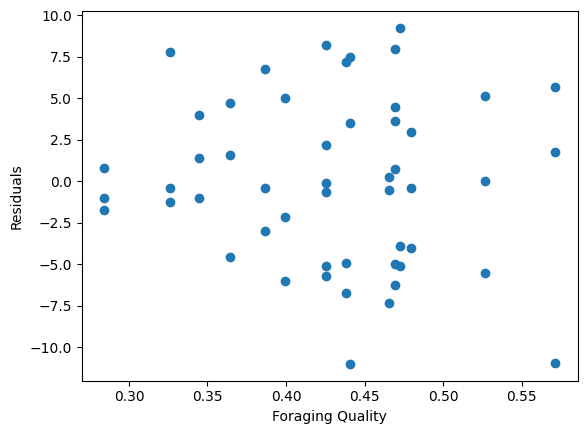

In [288]:
plt.scatter(dt['foraging_quality'], dt['residuals'])
plt.xlabel('Foraging Quality')
plt.ylabel('Residuals')

#np.corrcoef(dt['foraging_quality'], dt['residuals'])

# print r squared
r2_score(dt['foraging_quality'], dt['residuals'])

In [3]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Provided data
x_data = np.array([18.247769942650418,
 16.665125846862793,
 14.479167302449547,
 15.92466754383511,
 20.922000885009748,
 14.396667162577316,
 16.73587575554848,
 19.454858098711288,
 13.860667069753015,
 16.090600872039794,
 16.262000719706233,
 15.053251028060924,
 15.446500884162045,
 20.41775059700015,
 14.1116673151652,
 16.234688252210624,
 17.174300956726068,
 15.304750680923473,
 18.13423171410195,
 10.546000480651859,
 22.352501392364523,
 16.351294910206526,
 20.661834716796886,
 14.124834060668967,
 17.643143790108827,
 16.23387575149537,
 14.487000783284534,
 16.73587575554848,
 17.6163339614868,
 20.833751201629653,
 17.704214981624048,
 16.830000996589646,
 14.61800050735475,
 18.31730871934156,
 16.66425055265426,
 14.551000595092779,
 16.04681321978569,
 17.84950065612793,
 15.794400691986102,
 18.540429626192367,
 17.691500782966614,
 15.213667551676451,
 16.0364124915179,
 20.9775004386902,
 14.499834219614668,
 18.39169311523437,
 10.83950066566467,
 17.823100662231447,
 16.70381331443788,
 17.3350009918213,
 20.669251441955577])
y_data = np.array([5.482456140333333,
 8.852469959928571,
 9.2,
 7.084656084666666,
 5.854848484863637,
 5.090702947888889,
 8.077777777749999,
 9.6,
 8.494949495,
 8.796036585349999,
 5.729032258066667,
 4.7684210526,
 5.9,
 9.9631578948,
 5.982456140333333,
 7.2,
 9.608663181461539,
 6.0,
 9.109427609444445,
 7.971014492666666,
 5.075396825375,
 8.8902173913,
 8.137955182071428,
 8.6,
 7.23771929825,
 7.700729926999999,
 7.8035714285,
 8.714285714285714,
 5.984326018818181,
 7.3565217392,
 5.9375,
 8.62903225809091,
 6.660256410333333,
 5.30827067668421,
 5.31481481475,
 8.0,
 8.423180593,
 7.722077922090909,
 8.5,
 6.097222222222222,
 7.921511627923077,
 8.265873015857142,
 8.2,
 7.604166666625,
 3.5,
 7.137755102,
 7.0,
 4.834656084642857,
 9.7375,
 10.75,
 8.579218107])

# Increase maxfev parameter in curve_fit function
params, covariance = opt.curve_fit(briere_model, x_data, y_data, p0=initial_guess, maxfev=2000)

# Initial parameter guesses for optimization
initial_guess = [0.01, min(x_data) - 2, max(x_data) + 2]

# Fit the model using nonlinear least squares
params, covariance = opt.curve_fit(briere_model, x_data, y_data, p0=initial_guess)

# Extract fitted parameters
a_fit, Tmin_fit, Tmax_fit = params

# Generate smooth curve for visualization
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = briere_model(x_fit, a_fit, Tmin_fit, Tmax_fit)

# Plot data and fitted curve
plt.scatter(x_data, y_data, label="Data", color="blue")
plt.plot(x_fit, y_fit, label="Brière Fit", color="red")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("Brière Model Fit")
plt.legend()
plt.show()

# Return fitted parameters
a_fit, Tmin_fit, Tmax_fit


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [2]:
from sklearn.metrics import r2_score

r2 = r2_score(y_data, briere_model(x_data, a_fit, Tmin_fit, Tmax_fit))
r2


0.2796199151196015